### 1.0 Convolutional Neural Network

* convolutional layer
* relu layer
* pooling layer

In [ ]:
# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# machine learning
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# helper functions
from pathlib import Path
import requests
from tqdm.auto import tqdm
from timeit import default_timer as timer


# device
device = "cpu"

# print(torch.__version__)
# print(np.__version__)
# print(torchvision.__version__)

#### 2.0 Setup

* prepare & load data
* import helper functions
* create batches using data_loader
* automate train, test, eval functions

In [ ]:
# PREPARE & LOAD DATA
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# DECLARE ESSENTIAL INFO
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

"""
print(class_names)
print(class_to_idx)
print(train_data, "\n", test_data)
"""

# SET BATCHES
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

"""
print(train_dataloader, "\n", test_dataloader)
"""

# IMPORT HELPER FUNCTIONS
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import accuracy_fn

def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
    """
    Prints difference between start adn end time.
    """

    total_time = end - start
    print(f"Train time on {device} : {total_time: .3f} seconds")
    return total_time


# AUTOMIZE TRAIN/TEST/EVAL FUNCTIONS
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
    """
    Trains model based on train data from data_loader.
    """

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in tqdm(enumerate(data_loader), desc="Training Model..."):
        # put data on target device
        X, y = X.to(device), y.to(device)

        # make predictions
        y_pred = model.forward(X)

        # calculate & accumulate loss (wrongness)
        loss = loss_fn(y_pred, y)
        train_loss += loss 

        # calculate & accumulate acc
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # change logits -> prediction labels

        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # keep track of progress
        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples.")
    

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=device):
    """
    Performs a test loop with model going over
    test data from data_loader.
    """

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Making Predictions..."):
            X, y = X.to(device), y.to(device)

            test_pred = model.forward(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")


def eval_model(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            accuracy_fn):
    """
    Returns a dictionary containing the results of model.
    Built for easy comparison between different models.
    The core function is equivalent to that of the "test_step" function.
    """

    model.eval()
    loss, acc = 0, 0

    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Evaluating Model..."):
            # make predictions
            y_pred = model.forward(X)

            # accumulate loss & acc per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))
            
        # scale loss and acc to find average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(), 
            "model_acc": acc}

#### 3.0 CNN Model

In [ ]:
class FashionMNISTModelCNN(nn.Module):
    """
    Model architecture taht replicates TinyVGG model.
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
                        nn.Conv2d(in_channels=input_shape,
                                  out_channels=hidden_units,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.BatchNorm2d(hidden_units),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=hidden_units,
                                  out_channels=hidden_units,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.BatchNorm2d(hidden_units),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
                        nn.Conv2d(in_channels=hidden_units,
                                  out_channels=hidden_units,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.BatchNorm2d(hidden_units),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=hidden_units,
                                  out_channels=hidden_units,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1),
                        nn.BatchNorm2d(hidden_units),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2) 
        )

        self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(in_features=hidden_units*7*7,
                        out_features=output_shape)
        )
    
    # print shape to calculate in_features for nn.Linear()
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)

        return x

In [ ]:
torch.manual_seed(42)
model_cnn_1 = FashionMNISTModelCNN(input_shape=1,
                                   hidden_units=10,
                                   output_shape=len(class_names)).to(device)

In [ ]:
# FIND IN_FEATURES THROUGH PRINTING SHAPES
rand_image_tensor = torch.randn(size=(1, 28, 28))

"""
# model_cnn_1(rand_image_tensor.unsqueeze(dim=0))

rand_image_tensor = torch.randn(size=(1, 10, 7, 7))
print(rand_image_tensor.size())

flatten_tensor = nn.Flatten()
rand_image_flattened = flatten_tensor(rand_image_tensor)
print(rand_image_flattened.size())

# print(f"Original image shape: {rand_image_tensor.shape}")
# print(f"Unsqueezed image shape: {rand_image_tensor.unsqueeze(dim=0).shape}")
"""

model_cnn_1(rand_image_tensor.unsqueeze(dim=0))

#### 3.1 Exploring `nn.Conv2d()`

In [ ]:
# create dummy data
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

"""
print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image: \n {test_image}")
"""

In [ ]:
# model_cnn_1.state_dict()

In [ ]:
# create single conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=1)

test_image = test_image.unsqueeze(dim=0)
conv_output = conv_layer(test_image)
print(test_image.shape, "\n", conv_output.shape)

#### 3.2 Exploring `nn.nn.MaxPool2d()`

In [ ]:
test_image = images[1]

print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv layer: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv and max pool layer: {test_image_through_conv_and_max_pool.shape}")

#### 4.0 Set Loss Function & Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn_1.parameters(),
                            lr=0.1)

#### 5.0 Train & Test

In [ ]:
torch.manual_seed(42)
train_start_time_cnn = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n------------------")

    train_step(model=model_cnn_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    # don't normally test per epoch after train
    # test_step(model=model_cnn_1,
    #           data_loader=test_dataloader,
    #           loss_fn=loss_fn,
    #           accuracy_fn=accuracy_fn,
    #           device=device)
    
train_end_time_cnn = timer()
total_train_time = print_train_time(start=train_start_time_cnn,
                                    end=train_end_time_cnn,
                                    device=device)

In [ ]:
model_cnn_1_results = eval_model(
                model=model_cnn_1, # same model (already trained)
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn)

model_cnn_1_results

#### 6.0 Make Predictions on Random Test Samples

In [74]:
# make predictions on test dataset
# and plot predicitons
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    
    pred_probs = []
    model.to(device)
    model.eval() # disables dropout, uses population BN
    
    with torch.inference_mode(): # no gradient tracking
        for sample in data:
            # prepare sample data
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass (raw logits)
            pred_logits = model(sample)

            # get prediction probability
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            # get pred_prob off the GPU (not in this case)
            pred_probs.append(pred_prob.cpu())
            # print(pred_probs[:2])
            # print(type(pred_prob))

    # turn list in to tensor
    return torch.stack(pred_probs)

In [75]:
# sample, label = test_data[0]
# print(test_data)
# print()
# print(sample[0].shape)
# print(sample[0].size())
# print(sample)

# img, img_label = test_data[0][:10]
# print()
# print(img.shape, label)

In [76]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# view first sample
test_samples[0].shape

torch.Size([1, 28, 28])

In [77]:
# "squeeze" to get rid of batch dimension
# plt.imshow(test_samples[0].squeeze(), cmap="gray")

In [78]:
# make predictions
# model_cnn_1 should already be trained
pred_probs = make_predictions(model=model_cnn_1,
                              data=test_samples)

print(pred_probs[:2])
print(test_labels[:2])

tensor([[8.9505e-06, 2.6042e-05, 8.0282e-07, 7.9081e-07, 1.9906e-06, 8.9376e-01,
         1.8597e-05, 6.7733e-05, 2.7852e-03, 1.0333e-01],
        [2.0695e-03, 8.5683e-01, 3.6930e-04, 8.8714e-02, 3.7855e-02, 3.3685e-04,
         1.1190e-02, 1.3562e-04, 9.6907e-04, 1.5291e-03]])
[5, 1]


In [79]:
# convert prediction probability to labels
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)
print(test_labels)

tensor([5, 1, 9, 4, 3, 0, 4, 7, 1])
[5, 1, 7, 4, 3, 0, 4, 7, 1]


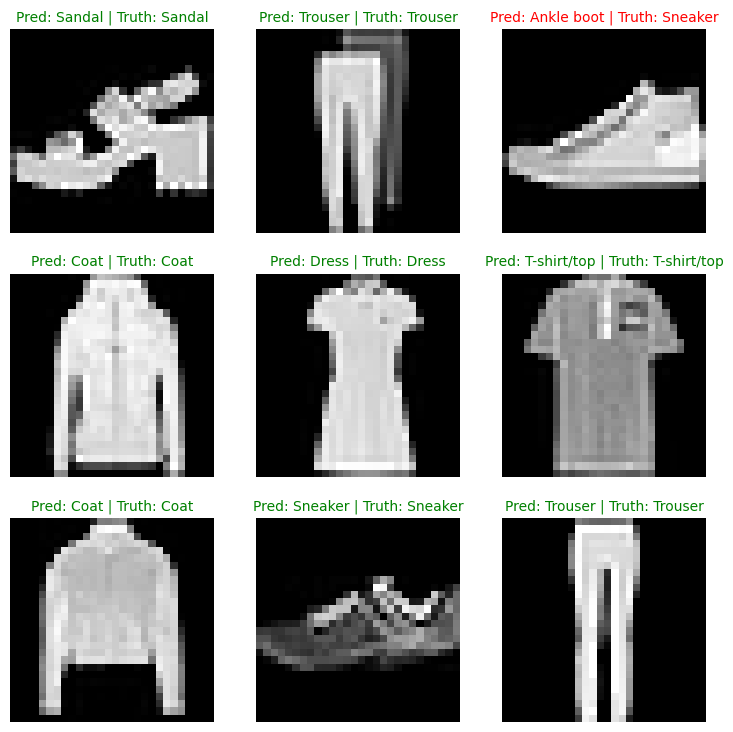

In [81]:
# plot predictions
plt.figure(figsize=(9, 9))
num_rows = 3
num_cols = 3

for i, sample in enumerate(test_samples):
    # create subplot
    plt.subplot(num_rows, num_cols, i+1)

    # plot target image (test image)
    plt.imshow(sample.squeeze(), cmap="gray")

    # prediction in text form (ex. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # get truth label
    truth_label = class_names[test_labels[i]]

    # create title
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # check for equality between pred & truth
    if pred_label == truth_label:
        # green title if correct prediction
        plt.title(title_text, fontsize=10, c="g")
    else:
        # red title if correct prediction
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

    

#### 6.1 Using Confusion Matrix

1. Make predictions with our trained model on the test dataset
2. Make confusion matrix `torchmetrics.ConfusionMatrix `
3. Plot confusion matrix using `mixtend.plotting.plot_confusion_matrix()`

In [89]:
import mlxtend
import torchmetrics
from tqdm.auto import tqdm
# print(mlxtend.__version__)
# print(torchmetrics.__version__)

# make predictions w/ trained model
y_preds = []
model_cnn_1.eval()
with torch.inference_mode():
    # goes through each batch of the test_dataloader
    for X, y in tqdm(test_dataloader, desc="Making Predictions.."):
        X, y = X.to(device), y.to(device)
        y_logit = model_cnn_1(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

# concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
# print(y_pred_tensor)
# print(len(y_pred_tensor))

0.11.4


Making Predictions..: 100%|██████████| 313/313 [00:02<00:00, 120.74it/s]

tensor([9, 2, 1,  ..., 8, 1, 7])
10000
